In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
from scipy.integrate import odeint

# 1. Exact Solution

In [91]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def bs_call(S,K,T,r,sigma,t):
    if S==0:
        return 0
    if T == t:
        return max(S-K,0)
    tau = T-t
    return S*norm.cdf(d1(S,K,tau,r,sigma))-K*exp(-r*tau)*norm.cdf(d2(S,K,tau,r,sigma))

def bs_call_no_sigma(S,K,T,r,sigma):
    return S-K*exp(-r*T)

In [103]:
# Exact solution when using transformed variable x=y
def exact(t,x):
    te=T-t
    S=L*(1+x)/(1-x)
    
    return bs_call(S,K,T,r,sigma,te)

# 2. Collocation solution based on Chebyshev Polunomials

In [92]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

## 2.1. Variables definition

In [93]:
#vars 

L   = 20.0 #20 gives a reasonable Smax of 278
nx  = 64
a   = 1.0;sigma=np.sqrt(2)
cfl = 0.9
r=0.01
r_sigma=r-1/2*sigma**2
K=70

N=18
TN=NT=120
M=2#order or diff equation - constant
T = 1

## 2.2. Chebyhev differentiation matrix

In [7]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.linalg import eig
from scipy.linalg import toeplitz
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
def chebdif(N,M):
    '''    
    Calculate differentiation matrices using Chebyshev collocation.
      
    Returns the differentiation matrices D1, D2, .. DM corresponding to the 
    M-th derivative of the function f, at the N Chebyshev nodes in the 
    interval [-1,1].   
    
    Parameters
    ----------
     
    N   : int 
          number of grid points
         
    M   : int
          maximum order of the derivative, 0 < M <= N - 1
    Returns
    -------
    x  : ndarray
         N x 1 array of Chebyshev points 
         
    DM : ndarray
         M x N x N  array of differentiation matrices 
        
    Notes
    -----
    This function returns  M differentiation matrices corresponding to the 
    1st, 2nd, ... M-th derivates on a Chebyshev grid of N points. The 
    matrices are constructed by differentiating N-th order Chebyshev 
    interpolants.  
    
    The M-th derivative of the grid function f is obtained by the matrix-
    vector multiplication
    
    .. math::
    
    f^{(m)}_i = D^{(m)}_{ij}f_j
     
    The code implements two strategies for enhanced accuracy suggested by 
    W. Don and S. Solomonoff :
    
    (a) the use of trigonometric  identities to avoid the computation of
    differences x(k)-x(j) 
    
    (b) the use of the "flipping trick"  which is necessary since sin t can 
    be computed to high relative precision when t is small whereas sin (pi-t) 
    cannot.
    
    It may, in fact, be slightly better not to implement the strategies 
    (a) and (b). Please consult [3] for details.
    
    This function is based on code by Nikola Mirkov 
    http://code.google.com/p/another-chebpy
    References
    ----------
    ..[1] B. Fornberg, Generation of Finite Difference Formulas on Arbitrarily
    Spaced Grids, Mathematics of Computation 51, no. 184 (1988): 699-706.
 
    ..[2] J. A. C. Weidemann and S. C. Reddy, A MATLAB Differentiation Matrix 
    Suite, ACM Transactions on Mathematical Software, 26, (2000) : 465-519
    
    ..[3] R. Baltensperger and M. R. Trummer, Spectral Differencing With A
    Twist, SIAM Journal on Scientific Computing 24, (2002) : 1465-1487 
           
    Examples
    --------
    
    The derivatives of functions is obtained by multiplying the vector of
    function values by the differentiation matrix. The N-point Chebyshev
    approximation of the first two derivatives of y = f(x) can be obtained
    as 
    
    >>> N = 32; M = 2; pi = np.pi
    >>> from pyddx.sc import dmsuite as dms
    >>> x, D = dms.chebdif(N, M)        # first two derivatives
    >>> D1 = D[0,:,:]                   # first derivative
    >>> D2 = D[1,:,:]                   # second derivative
    >>> y = np.sin(2*pi*x)              # function at Chebyshev nodes
    >>> plot(x, y, 'r', x, D1.dot(y), 'g', x, D2.dot(y), 'b')
    >>> xlabel('$x$'), ylabel('$y$, $y^{\prime}$, $y^{\prime\prime}$')
    >>> legend(('$y$', '$y^{\prime}$', '$y^{\prime\prime}$'), loc='upper left')
    '''

    if M >= N:
        raise Exception('numer of nodes must be greater than M')
        
    if M <= 0:
         raise Exception('derivative order must be at least 1')

    DM = np.zeros((M,N,N))
    
    n1 = int(N/2); n2 = int(round(N/2.))     # indices used for flipping trick
    k = np.arange(N)                    # compute theta vector
    th = k*np.pi/(N-1)

    # Compute the Chebyshev points

    #x = np.cos(np.pi*np.linspace(N-1,0,N)/(N-1))                # obvious way   
    x = np.sin(np.pi*((N-1)-2*np.linspace(N-1,0,N))/(2*(N-1)))   # W&R way
    x = x[::-1]
    
    # Assemble the differentiation matrices
    T = np.tile(th/2,(N,1))
    DX = 2*np.sin(T.T+T)*np.sin(T.T-T)               # trigonometric identity
    DX[n1:,:] = -np.flipud(np.fliplr(DX[0:n2,:]))    # flipping trick
    DX[range(N),range(N)]=1.                         # diagonals of D
    DX=DX.T

    C = toeplitz((-1.)**k)           # matrix with entries c(k)/c(j)
    C[0,:]  *= 2
    C[-1,:] *= 2
    C[:,0] *= 0.5
    C[:,-1] *= 0.5

    Z = 1./DX                        # Z contains entries 1/(x(k)-x(j))
    Z[range(N),range(N)] = 0.        # with zeros on the diagonal.          

    D = np.eye(N)                    # D contains differentiation matrices.
                                          
    for ell in range(M):
        D = (ell+1)*Z*(C*np.tile(np.diag(D),(N,1)).T - D)      # off-diagonals    
        D[range(N),range(N)]= -np.sum(D,axis=1)        # negative sum trick
        DM[ell,:,:] = D                                # store current D in DM

    return x,DM


## 2.3. Variable coefficients 

In [16]:
def g2(x):
    return -(1/8)*(sigma**2)*((x+1)**2)*((1-x)**2)

In [17]:
def g3(x,L):
    return -(r/2)*(x+1)*(1-x)-(1/8)*sigma**2*(x+1)**2*(1-x)*L

## 2.4. Functions

In [94]:
from itertools import combinations
def backslash(A,b):
    num_vars = A.shape[1]
    rank = np.linalg.matrix_rank(A)
    if rank == num_vars:              
        sol = np.linalg.lstsq(A, b)[0]    # not under-determined
    else:
        for nz in combinations(range(num_vars), rank):    # the variables not set to zero
            try: 
                sol = np.zeros((num_vars, 1))  
                sol[nz, :] = np.asarray(np.linalg.solve(A[:, nz], b))
                
            except np.linalg.LinAlgError:     
                pass                    # picked bad variables, can't solve
    return sol

In [95]:
def pend(y, t, A):#only internal points 
    
    #y = np.zeros(len(y0))
    #y_start = - D1.dot(y[0])[0,0]
    y_middle = y[1:-1]
    #res = backslash(A,y_middle)
    #y_end = - D1.dot(y[-1])[-1,-1]
    #res = [y_start] + res + [y_end]
    # OR should I multiply all y0 and D1?
    y_start=y[0]#-D1.dot(y)[0]
    y_end = y[-1]#-D1.dot(y)[-1]
    #not sure if this is cheating
    #y_end = D1[-1,1:].dot(y0[1:])
    #res = (A).dot(y)[1:-1]
    #print("res")
    #print(res)
    
    
    
    
    y_hat = backslash(A,y[1:-1])
    #A[0] = A[0]/y0[1:-1]# move these 3 lines above backslash to get another version
    #x, D = chebdif(N, M)        
    #y = [np.sin(2*np.pi*xi) for xi in x]
    #y_hat = backslash(A,y[1:-1]) # Cheb coefs of y0
    y_hat=y_hat*t
    res = (A).dot(y_hat)
    res = np.append(np.append(y_start,res),y_end)
    #res = res[0]
    #res[0]=y_start
    #res[-1]=y_end
    return res

In [96]:
def rungekutta4(f, y0, t, A):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        #print(y[i])
        h = t[i+1] - t[i]
        k1 = f(y[i], t[i], A)
        
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., A)
        
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., A)
        k4 = f(y[i] + k3 * h, t[i] + h, A)
        #try R-K dependent on delta_t
        k2 = f(y[i] + k1 * h / 2., h / 2., A)
        
        k3 = f(y[i] + k2 * h / 2., h / 2., A)
        k4 = f(y[i] + k3 * h,  h, A)
        
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
        
    return y

In [97]:
def make_matrix(D,x):
    D1 = D[0,:,:]                   # first derivative
    D2 = D[1,:,:]                   # second derivative
    D0=np.identity(D.shape[1])
    #D0[0,:]=0
    D0[-1,:]=0

    for j in range(D.shape[1]):
        for i in range(D.shape[2]):
            if i== 0 or i == D.shape[1]-1:  
                D1[j,i]=D1[j,i]*(0)
                D2[j,i]=D2[j,i]*0
            else: 
                
                D1[j,i]=D1[j,i]*g3(x[j],L)
                D2[j,i]=D2[j,i]*g2(x[j])
    D0=D0*r
    
    A=D0.T+D1.T+D2.T
    A[0]=A[-1]=A[0]*0
    
    A[:,0]=D0[0]
    A[:,-1]=D0[-1]  
    
    return A

In [98]:
def cheb_int( N, TN,L ):
    x, D = chebdif(N, M)        # first two derivatives
    
    D1 = D[0,:,:]                   # first derivative
    D2 = D[1,:,:]                   # second derivative
    A = make_matrix(D,x)
    A = A[1:-1,1:-1]
    
    #get initial values
    y0 = [max(L*(xi+1)/(1-xi)-K,0) for xi in x]
    y0[-1] = 0 #boundary
    
    t4 = np.linspace(0, T, TN)
    t4 = np.flip(t4)
    sol4 = rungekutta4(pend, y0, t4, A)
    
    return (t4,x,sol4)

## 2.5. Implementation

In [23]:
x, D = chebdif(N, M) 
A=make_matrix(D,x)

In [99]:
# boundary values for y where y is S ported to [-1,1]
y0=[L*(1+x1)/(1-x1) for x1 in x]
y0[-1]=0

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [100]:
(t4,x,sol4)=cheb_int( N, NT, L )


c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()


In [26]:
from scipy.integrate import odeint
sol = odeint(pend, y0, t4, (A[1:-1,1:-1],))

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


###   2.5.1. How the solution behaves with time

In [101]:
fig,ax=plt.subplots()

ax.plot(t4,sol4[:,0], ':', color='blue', lw=1)
ax.plot(t4,sol4[:,2], 'o', color='gray', lw=1)
ax.plot(t4,sol4[:,3], '+', color='lime', lw=1)
ax.plot(t4,sol4[:,-1], '+', color='magenta', lw=1)
    
plt.rc('font', size=14)
#plt.gca().set_xlim([0,10])
#plt.gca().set_ylim([0,28000])
plt.xlabel('t')
plt.ylabel(r'u');
plt.legend(['t1', 't2', 't3'], frameon=False);

### 2.5.2. How the solution behaves in space (S or y)

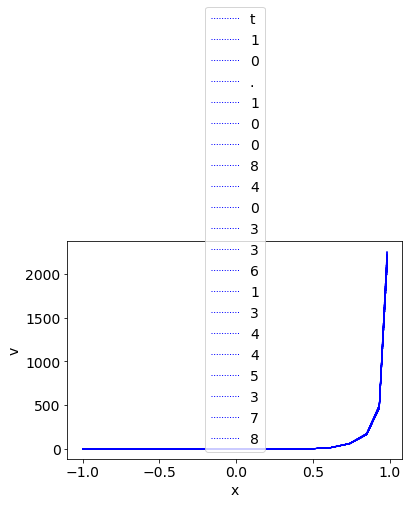

In [32]:
fig,ax=plt.subplots()
for ix in range(len(t4)-12):
    ax.plot(x,sol4[ix,], ':', color='blue', lw=1)

    plt.rc('font', size=14)
    #plt.gca().set_xlim([0,10])
    #plt.gca().set_ylim([0,500])
    plt.xlabel('x')
    plt.ylabel(r'v');
    plt.legend('t1'+str(t4[ix]), frameon=True);

## 3. Visualize approximation vs Exact

In [104]:
# Visualizing in terms of S
S=[L*(1+xi)/(1-xi) for xi in x]

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [105]:
Smax=S[1]
Smax

2329.223831549756

In [41]:
%matplotlib qt

In [106]:
# Make data.

x, D = chebdif(N, M)        # first two derivatives

A=make_matrix(D,x)

(t4,x,sol4)=cheb_int( N, NT, L )
xn=x[1:]
X, Y = np.meshgrid(xn, t4)

Z = np.zeros((len(t4),len(xn)))
for i in range(len(t4)):
    for j in range(len(xn)):
        Z[i,j]=exact(t4[i],xn[j])
        
        
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                       linewidth=0, antialiased=False)

surf = ax.plot_surface(X, Y, sol4[:,1:], rstride=1, cstride=1,
                        cmap=cm.coolwarm,
                        alpha=1,
                       linewidth=0, antialiased=False)
# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()


# 5. Studying Convergence of the Error

In [107]:
 #use the same data as in the plot above

In [109]:
sol4Z = sol4[:,1:]

In [110]:
np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf)

0.08212692262488827

In [112]:
pd.DataFrame(np.abs((sol4Z-Z)/Z)).to_csv("errors.csv")

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


### 5.1. Error as a function of number of S/x points

In [113]:
Nmin = 4
n = Nmin
i = 1

ns=[]
err=[]

norminf=[]
while ( n <= 180 ):  
    x, D = chebdif(n, M)        # first two derivatives

    A=make_matrix(D,x)

    (t4,x,sol4)=cheb_int( n, NT, L )
    sol4Z = sol4[:,1:]
    xn=x[1:]
    
    Z = np.zeros((len(t4),len(xn)))
    for i in range(len(t4)):
        for j in range(len(xn)):
            Z[i,j]=exact(t4[i],xn[j])
    norminf.append(np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf))
    ns.append(n)
    n = n * 2;
# Plotting the error;
fig,ax=plt.subplots()

ax.plot(ns,norminf, ':', color='red', lw=1)
#ax.set_xscale('log')
ax.set_yscale('log')

plt.rc('font', size=14)
#plt.gca().set_xlim([0,10])
plt.xlabel('N')
plt.ylabel('error');

plt.legend(['Infinity norm'], frameon=True);

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()


## 5.2. Error as a function of max time T

In [86]:
# For  t
Nmin = 40
t = tmin = 15

ts=[]
err=[]

norminf=[]
while ( t <= 205 ):  
    x, D = chebdif(Nmin, M)        # first two derivatives

    A=make_matrix(D,x)

    (t4,x,sol4)=cheb_int( Nmin, t, L )
    sol4Z = sol4[:,1:]
    xn=x[1:]
    
    Z = np.zeros((len(t4),len(xn)))
    for i in range(len(t4)):
        for j in range(len(xn)):
            Z[i,j]=exact(t4[i],xn[j])
    norminf.append(np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf))
    ts.append(t)
    t = t + 5;
# Plotting the error;
fig,ax=plt.subplots()

ax.plot(ts,norminf, ':', color='red', lw=1)
#ax.set_xscale('log')
ax.set_yscale('log')

plt.rc('font', size=14)
#plt.gca().set_xlim([0,10])
plt.xlabel('T')
plt.ylabel('error');

plt.legend(['Infinity norm'], frameon=True);

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()


## 5.2. Error as a function of L

In [89]:
#dependence on L
l = 4
Nmin = 40
t = tmin = 15

ls=[]
err=[]

norminf=[]
while ( l <= 40 ):  
    x, D = chebdif(Nmin, M)        # first two derivatives

    A=make_matrix(D,x)

    (t4,x,sol4)=cheb_int( Nmin, t, l )
    sol4Z = sol4[:,1:]
    xn=x[1:]
    
    Z = np.zeros((len(t4),len(xn)))
    for i in range(len(t4)):
        for j in range(len(xn)):
            Z[i,j]=exact(t4[i],xn[j])
    norminf.append(np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf))
    ls.append(l)
    l = l + 1;
# Plotting the error;
fig,ax=plt.subplots()

ax.plot(ls,norminf, ':', color='red', lw=1)
#ax.set_xscale('log')
ax.set_yscale('log')

plt.rc('font', size=14)
#plt.gca().set_xlim([0,10])
plt.xlabel('L')
plt.ylabel('error');

plt.legend(['Infinity norm'], frameon=True);

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()
c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()
